In this homework, you will debias word embeddings using the method from [Bolukbasi et al. 2016](https://arxiv.org/abs/1607.06520) and interpreted through [Vargas and Cotterell 2020](https://arxiv.org/abs/2009.09435). 

In [1]:
import re
from gensim.models import KeyedVectors
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
glove = KeyedVectors.load_word2vec_format("../data/glove.6B.100d.100K.w2v.txt", binary=False)

In [3]:
# let's print one sample vector just to see what it looks like
print(glove["man"].shape)
print(glove["man"])

(100,)
[ 3.7293e-01  3.8503e-01  7.1086e-01 -6.5911e-01 -1.0128e-03  9.2715e-01
  2.7615e-01 -5.6203e-02 -2.4294e-01  2.4632e-01 -1.8449e-01  3.1398e-01
  4.8983e-01  9.2560e-02  3.2958e-01  1.5056e-01  5.7317e-01 -1.8529e-01
 -5.2277e-01  4.6191e-01  9.2038e-01  3.1001e-02 -1.6246e-01 -4.0567e-01
  7.8621e-01  5.7722e-01 -5.3501e-01 -6.8228e-01  1.6987e-01  3.6310e-01
 -7.1773e-02  4.7233e-01  2.7806e-02 -1.4951e-01  1.7543e-01 -3.7573e-01
 -7.8517e-01  5.8171e-01  8.6859e-01  3.1445e-02 -4.5897e-01 -4.0917e-02
  9.5897e-01 -1.6975e-01  1.3045e-01  2.7434e-01 -6.9485e-02  2.2402e-02
  2.4977e-01 -2.1536e-01 -3.2406e-01 -3.9867e-01  6.8613e-01  1.7923e+00
 -3.7848e-01 -2.2477e+00 -7.7025e-01  4.6582e-01  1.2411e+00  5.7756e-01
  4.1151e-01  8.4328e-01 -5.4259e-01 -1.6715e-01  7.3927e-01 -9.3477e-02
  9.0278e-01  5.0889e-01 -5.0031e-01  2.6451e-01  1.5443e-01 -2.9432e-01
  1.0906e-01 -2.6667e-01  3.5438e-01  4.9079e-02  1.8018e-01 -5.8590e-01
 -5.5542e-01 -2.8987e-01  7.4278e-01  3.4530

Now let's calculate the cosine similarity of that vector ("man") with a set of other vectors ("king" and "cabbage").  This returns two cosine similarities, the first cos(man, king) and the second cos(man, cabbage).

In [4]:
glove.cosine_similarities(glove["man"], [glove["king"], glove["cabbage"]])

array([0.5118681 , 0.04780922], dtype=float32)

Let's use that machinery to find the differences between "man" and "woman" and a set of target terms.

In [5]:
targets=["doctor", "nurse", "actor", "actress", "mechanic", "librarian", "architect", "magician", "cook", "chef"]
diffs={}
for term in targets:
    
    m,w=glove.cosine_similarities(glove[term], [glove["man"], glove["woman"]])
    diffs[term]=m-w

for k, v in sorted(diffs.items(), key=lambda item: item[1], reverse=True):
    print("%.3f\t%s" % (v,k))

0.109	magician
0.095	mechanic
0.082	architect
0.046	actor
0.035	cook
0.012	chef
-0.024	doctor
-0.110	librarian
-0.154	actress
-0.158	nurse


We can see a gender difference here, where "man" is more aligned "magician" and "mechanic" and "woman" is more aligned with "actress" and "nurse".

**Q1.** Let's debias those embeddings, using the method from [Bolukbasi et al. 2016](https://arxiv.org/abs/1607.06520) and interpreted through [Vargas and Cotterell 2020](https://arxiv.org/abs/2009.09435).  Debiasing embeddings requires two steps: finding the gender subspace and then subtracting the orthogonal projection onto that subspace from the original embedding.  Let's start with the first step: creating "defining sets" that capture the variation:

$$
D_1 = \{man, woman\}\\
D_2 = \{mr., mrs.\}
$$

Following Vargas and Cotterell, we can find the gender subspace by constructing a new matrix $D'$ by substracting the embedding for a word in a defining set from the average of embeddings in that set. Using $e_{word}$ to denote the embedding for a word, this process would results in the following for the defining sets above:

$$
\begin{bmatrix}
e_{man} - \textrm{mean}(e_{man},e_{woman}) \\
e_{woman} - \textrm{mean}(e_{man},e_{woman})\\
e_{mr.} - \textrm{mean}(e_{mr.},e_{mrs.})\\
e_{mrs.} - \textrm{mean}(e_{mr.},e_{mrs.})\\
\end{bmatrix}
$$

If the original embeddings (e.g., for $e_{man}$) are 100 dimensions (and so the mean over any set of embeddings is also 100 dimensions), then the resulting matrix $D'$ should be $4 \times 100$.  Create this matrix $D'$ and name it `subspace_matrix`.

In [6]:
D1=["man", "woman"]
D2=["mr.", "mrs."]

# get the mean vector for each defining set   
avg1 = np.mean([glove[term] for term in D1], axis=0)
avg2 = np.mean([glove[term] for term in D2], axis=0)

# get the diff between each word and the defining set
diff1 = [glove[term] - avg1 for term in D1]
diff2 = [glove[term] - avg2 for term in D2]

# get the gender subspace 
subspace_matrix = np.asarray(diff1 + diff2)

In [7]:
# This should be (4,100)
print(subspace_matrix.shape)

(4, 100)


Step two is to run [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) over that `subspace_matrix` matrix.  The gender subspace in this example is the first principle component of that process. Here's how you run PCA on a random matrix to get the first principle component.

In [8]:
fake_matrix=np.random.rand(3,3)
print("fake matrix:")
print(fake_matrix)

# We only need one principle component, so we'll set n_components=1
pca=PCA(n_components=1).fit(fake_matrix)
subspace=pca.components_[0]

print("first principle component:")
print(subspace)

fake matrix:
[[0.34964222 0.65382736 0.91272658]
 [0.08986586 0.05273594 0.6213597 ]
 [0.4471431  0.79695806 0.06589927]]
first principle component:
[ 0.31790408  0.64488868 -0.695022  ]


In [9]:
# You'll see that this subspace is already normalized to unit length:
print(subspace)
print(subspace/np.sqrt(np.dot(subspace, subspace)))

[ 0.31790408  0.64488868 -0.695022  ]
[ 0.31790408  0.64488868 -0.695022  ]


**Q2.** Run PCA on that subspace matrix to get the subspace axis.

That subspace is the gender axis. You'll remember from class that we find the orthogoal projection of any unit-normalized vector $w$ onto a subspace $b$ by:

$$
w_b = \textrm{dot}(w,b) \; b
$$

If $b$ and $x$ are 100 dimensions, $w_b$ is 100 dimensions too.  The debiased vector $w_d$ is then simply $w - w_b$.  

**Q3.** Debias the vectors for "man", "woman", and the targets used above ("doctor", "nurse", "actor", "actress", "mechanic", "librarian", "architect", "magician", "cook", "chef") and see if debiasing changes the differences between these terms and "man"/"woman" as noted above.  Glove embeddings are not normalized ahead of time, so be sure to normalize them before carrying out your projection (i.e., dividing vector v by $\sqrt{\textrm{dot}(v,v)}$).


**check-plus**. Reflect in 100 words on the differences between this gender axis construction and the axis construction in SemAxis.  How are they different?

In [10]:
# run PCA on the gender subspace
pca=PCA(n_components=1).fit(subspace_matrix)
gender=pca.components_[0]

# include `man` and `woman` to the target list
targets.extend(["man", "woman"])

# get the normalized embedding vector for each term, keyed by the term 
norm = {term:(glove[term]/np.sqrt(np.dot(glove[term], glove[term]))) for term in targets}

# subtracting the projection vector from its original embedding vector
debiased = {k:(v-np.dot(v, gender)*gender) for k,v in norm.items()}

0.109	magician
0.095	mechanic
0.082	architect
0.046	actor
0.035	cook
0.012	chef
-0.024	doctor
-0.110	librarian
-0.154	actress
-0.158	nurse


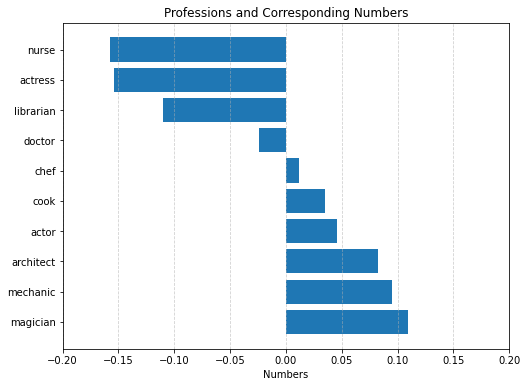

In [11]:
# plot the difference between each target term and man/woman

targets=["doctor", "nurse", "actor", "actress", "mechanic", "librarian", "architect", "magician", "cook", "chef"]
diffs={}
for term in targets:
    
    m,w=glove.cosine_similarities(glove[term], [glove["man"], glove["woman"]])
    diffs[term]=m-w

keys = []
values = []
for k, v in sorted(diffs.items(), key=lambda item: item[1], reverse=True):
    print("%.3f\t%s" % (v,k))
    keys.append(k)
    values.append(v)

plt.figure(figsize=(8, 6))  
plt.barh(keys, values)
plt.xlabel('Numbers')
plt.title('Professions and Corresponding Numbers')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(-0.2, 0.2)
plt.show()

0.041	cook
0.028	mechanic
0.026	architect
-0.002	actor
-0.004	magician
-0.005	nurse
-0.024	actress
-0.024	doctor
-0.026	librarian
-0.028	chef


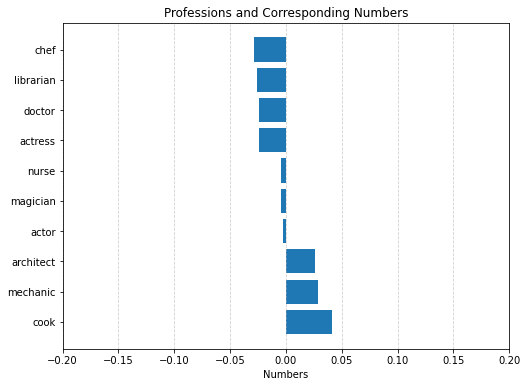

In [12]:
# plot the difference between each target term and man/woman, after debiasing

targets=["doctor", "nurse", "actor", "actress", "mechanic", "librarian", "architect", "magician", "cook", "chef"]
diffs={}
for term in targets:
    
    m,w=glove.cosine_similarities(debiased[term], [norm["man"], norm["woman"]])
    diffs[term]=m-w

keys = []
values = []
for k, v in sorted(diffs.items(), key=lambda item: item[1], reverse=True):
    print("%.3f\t%s" % (v,k))
    keys.append(k)
    values.append(v)

plt.figure(figsize=(8, 6))  
plt.barh(keys, values)
plt.xlabel('Numbers')
plt.title('Professions and Corresponding Numbers')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(-0.2, 0.2)
plt.show()

In general, debiasing via gender axis construction seems to work, as reflected in minimizing the distance between the target word embedding and the gender space. It actually works best for words that are most biased, such as `nurse` and `magician`, in which the gender information is almost completely erased. As for words that are not extremely biased, debiasing is not as effective. 

As for debiasing via SemAxis, judging only from cosine similarity scores, there's still biases that are not fully removed--the cosine similarity scores have more extreme numbers than the ones shown in the above plot. It feels to me more intuitive to decompose the emebdding vector into some subspace and the rest of everything else. As for SemAxis, it is sometimes difficult to control for the variation within the defining sets. When the defining sets contain multiple pairs of words, it is also more difficult to make sense of the commonality of these sets. 